# Classification of Personal Story Audio Data As True or False

# 1 | Author

**Kasey Purvor**
**200851709**

# 2 | Problem Formulation

This project focuses on developing a machine learning model to **predict whether an audio story is true or false**. This task is a **supervised binary classification problem**, where the objective is to **build a model that accurately classifies an audio recording as either representing a true or a false story.** 

**Objectives**

*   Explore and evaluate different machine learning models to distinguish true and false audio stories.
*   Investigate effective feature extraction and reduction techniques to create data that captures the characteristics relevant for determining truthfulness.
*   Optimise model performance by tuning hyperparameters and employing techniques to mitigate overfitting.

**What's Interesting & Challenging**

*   **Subjectivity and Context**: While the data is labelled - determining the truthfulness of a story can often be subjective and context-dependent, posing a challenge for developing a model that generalises well across different situations. A story may be a labelled as false but contain true elements - of which the reader may have read with truth like characteristics. 
*   **Feature Extraction**: Extracting features from audio data that effectively capture the nuances and subtle cues indicative of truthfulness or falsehood is a complex task.
*   **Data Availability**: Building a robust model requires a substantial dataset of labelled audio stories, which may be difficult to acquire or curate.

This project aims to address these challenges by exploring and comparing different machine learning models, feature extraction techniques, and validation strategies to develop a reliable system for detecting true or false audio stories.


# 3 | Methodology
The project is structured in the following stages

### Performance Metrics
Model performance is evaluated using the following metrics:

*   **Accuracy:** The proportion of correctly classified instances among the total instances.
*   **Precision:** The proportion of true positive predictions among the total predicted positives.
*   **Recall (Sensitivity):** The proportion of true positive predictions among the total actual positives.
*   **F1-Score:** The harmonic mean of precision and recall.

    **For all validation tasks `accuracy` is used. As the data is balanced and their is no weighted cost associated with misclassification it provides a straightforward measure of model performance.**
    
### Data Acquisition and Pre-processing

*   Audio recordings are read from the hard drive and metadata is loaded from a CSV file.
*   The truthfulness column in the metadata is converted to binary data.

### Data Splitting and Feature Extraction

*   The data is split into training and testing sets **before** feature extraction to prevent data leakage. 80% of the data is used for training and 20% is used for testing.
*   Audio recordings are divided into non-overlapping 30-second segments.
*   Features are extracted from each audio segment, including:
    *   **Acoustic Features:** `Pitch, Voicing, Energy, Power, MFCCs.`
    *   **Phonetic Features:** `Shimmer`.
*   Features are aggregated by calculating the mean, standard deviation, minimum, and maximum for each to reduce data size.

### Feature Scaling
*   Standard scaling is applied to the training and testing data **separately**.

### Feature Reduction

*   **Highly Correlated Features:** Features with a correlation above `0.85` are removed. This is done for all features and then again later for just the MFCC data.
*   **PCA:** PCA is applied to the MFCC data to reduce its dimensionality. Analysis determined that `10 principal components` captured 95% of the variance.
*   **RFECV:** RFECV is used to select the most relevant features based on model performance. The features  **pitch\_mean**,  **pitch\_min**,  **4**,  **5**,  **7**  are removed.

### Model Training and Hyperparameter Tuning

*   Five classification models are evaluated and have their hyperparameters tuned using GridSearchCV with 5-fold cross-validation repeated 5 times:
    *   Logistic Regression
    *   SVM
    *   Random Forest
    *   Gradient Boosting
    *   KNN
*   **Training Task:** The models are trained to predict whether an audio story is true or false based on the extracted and processed features.
*   **Validation Task:** The models are evaluated during hyperparameter tuning using the  k-fold-cross-validation strategy within GridSearchCV. This helps select the best hyperparameters for each model.

### Model Ensemble

*   An ensemble model is created using the VotingClassifier with soft voting.
*   The ensemble combines the predictions from the five best-performing models identified during the hyperparameter tuning stage.

### Model Performance Evaluation
  
*   The afforementioned metrics are calculated for both the individual models and the ensemble model on the held-out testing data.

### Other Tasks

*   **Exploratory Data Analysis (EDA):** Before feature reduction, descriptive statistics are calculated for some features and their distributions are visualised using histograms and box plots. Pair plots are used to visualise relationships between features. These analyses help understand the characteristics of the data and inform feature engineering and reduction decisions.



**All the necessary modules are imported here to begin**

In [82]:
# IMPORT ALL THE NECESSARY MODULES FOR THE PROJECT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import IPython.display as ipd
import librosa
import json
%pip install praat-parselmouth
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
# sklearn modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFECV
# parselmouth modules
from parselmouth.praat import call
import parselmouth

Note: you may need to restart the kernel to use updated packages.


# 4 |  Implemented ML Pipelines

Each subsection will provide a detailed overview of the individual stages included in the ML prediction pipelines. These stages include:

**Transformation Stage (Section 4.1)**: This stage focuses on feature engineering and data transformation techniques that convert raw data into a suitable format for model training.

**Model Stage (Section 4.2)**: This stage involves the application of various machine learning algorithms to train models on the transformed data.

**Ensemble Stage (Section 4.3)**: This stage explores the ensemble methods used to combine multiple models to improve prediction accuracy and robustness.

A graphical overview of the pipeline is created: 

**[Split Data] ==> [Extract Features] ==> [Remove Correlated features] ==> [Scaling] ==> [MFCC PCA] ==> [Scaling] ==> [Remove Correlated features] ==> [RECF] ==> [Model Stage] ==> [Ensemble Stage]**

## 4.1 | Transformation Stage

### 4.1.1 Data Acquisition and Preprocessing

*   **Function:** `Initial_setup()`: This function sets up the environment for reading audio data and their corresponding labels. It identifies the directory containing .wav files and reads metadata from a CSV file.
*   **Output:**
    *   `file_paths`: A list of paths to audio files.
    *   `story_attributes`: A Pandas DataFrame containing metadata, including a binary variable 'True_story' indicating whether a story is true or deceptive.
* **Notes** While no actual audio data is extracted at this point - as the data is on the HDD it is read into memory in the feature extraction stage. 



In [83]:
# INITIAL SET UP 
def initial_setup():
    story_directory_path = 'content/stories_data/'

    # Use glob to find all .wav files in the specified directory
    sample_path = story_directory_path + '*.wav'
    file_paths = glob.glob(sample_path)

    # Display the number of files found
    print('Story Files Found: ', len(file_paths))

    # ensure linux path notation is used
    file_paths = [file.replace('\\','/') for file in file_paths]
        
    # read the csv file into a dataframe 
    story_attributes = pd.read_csv('content/story_attributes.csv')

    # turn the Story_type column into a binary variable
    story_attributes['Story_type'] = story_attributes['Story_type'].map({'true_story': 1, 'deceptive_story': 0})

    # rename the story_type column to True_Story
    story_attributes = story_attributes.rename(columns={'Story_type': 'True_story'})
    
    return file_paths, story_attributes

### 4.1.2 | Feature Extraction

This section handles the extraction on features from the raw audio data. Audio clips are divided into 30-second segments and the features are extracted from each segment. While both feature extraction and train_test_split occur here - the splitting is applied to the File_IDs which effectively means the data was split before features are extracted. 

This stage is performed due to the extremely high dimensionality of of audio data. IT would be prohibitively costly to retain the raw data. The justification for the features themselves are provided in section 5.2. 

*   **Functions:** This section defines functions for segmenting audio and extracting features. 
    *    `(Internal)  extract_segments(file_path, segment_duration)`: This function divides audio files into 30-second segments and returns them.
    *    `(Internal) extract_features(file_paths, story_attributes)`: Extracts various features from each audio segment.
    *   `STAGE_extract_and_split()`: Calls the 2 internal functions to perform the feature extraction and data splitting process.
*   **Outputs:**
    *   `X_train`, `X_test`: The training and testing data matrices.
        *   **Acoustic Features:**
            *   Pitch: Mean, standard deviation, minimum, and maximum of the fundamental frequency (f0).
            *   Voicing: Ratio of voiced to unvoiced frames.
            *   Energy: Mean, standard deviation, minimum, and maximum of the root mean square (RMS) energy.
            *   Power: Mean, minimum, and maximum of the squared audio signal.
            *   MFCCs (Mel-Frequency Cepstral Coefficients): Mean, standard deviation, minimum, and maximum of the first 13 MFCCs.
        *   **Phonetic Features:**
            *   Shimmer: Mean, standard deviation, minimum, and maximum of the shimmer, a measure of vocal stability.
    *   `y_train`, `y_test`: A list of truth labels corresponding to each audio segment.

In [84]:
# FEATURE EXTRACTION
# extract segments from each audio file
def extract_segments(file_path, segment_duration=30):
    # print(file_path)
    audio, sample_rate = librosa.load(file_path)
    num_segments = int((len(audio) / sample_rate) // segment_duration)
    segments = []
    for i in range(num_segments):
        start_time = i * segment_duration
        start_index = int(start_time * sample_rate)
        end_index = start_index + int(segment_duration * sample_rate)
        segment = audio[start_index:end_index]
        segments.append(segment)
    
    return segments, sample_rate

# function that turns audio data into extracted features
def extract_features(file_paths, story_attributes):

    y = []
    X = pd.DataFrame()

    # iterate through the files and build the X and y matrices
    for file in file_paths:
        fileID = file.split('/')[-1]

        # store the files truth label (y)
        yi = story_attributes.loc[story_attributes['filename'] == fileID, 'True_story'].values[0]
        print(fileID, yi)
        
        # extract the audio segments and loop through
        segments, sample_rate = extract_segments(file)
        for audio_segment in segments:
            
            # add the segment label to y 
            y.append(yi)
            
            # ACCOUSTIC FEATURES   
            # Pitch and voiced region fraction 
            f0, voiced_flag, voiced_probs = librosa.pyin(y=audio_segment, fmin=65, fmax=300, sr=sample_rate) 
            pitch_mean = np.mean(f0[voiced_flag]) # only the voiced frames are considered
            pitch_std = np.std(f0[voiced_flag])  # only the voiced frames are considered
            pitch_min = np.min(f0[voiced_flag])  # only the voiced frames are considered
            pitch_max = np.max(f0[voiced_flag])  # only the voiced frames are considered
            voiced_to_unvoiced_ratio = np.mean(voiced_flag)
            voiced_fr = np.mean(voiced_flag)
           
            # Energy
            energy = librosa.feature.rms(y=audio_segment)[0]
            energy_mean = np.mean(energy)
            energy_std = np.std(energy)
            energy_min = np.min(energy)
            energy_max = np.max(energy)
            
            # power
            power = audio_segment**2
            power_mean = np.mean(power)
            power_min = np.min(power)
            power_max = np.max(power)
            
            # MFCCs
            mfccs = librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=13)
            # print('mfccs shape: ', mfccs.shape)
            # print(mfccs.shape)
            mfccs_mean = np.mean(mfccs, axis=1)
            mfccs_std = np.std(mfccs, axis=1)
            mfcss_min = np.min(mfccs, axis=1)
            mfcss_max = np.max(mfccs, axis=1)           
            # -------------------------------------------------
            
            # PHONETIC FEATURES                        
            #  Shimmer using parselmouth
            snd = parselmouth.Sound(audio_segment, sampling_frequency=sample_rate) # turn the audio into a parselmouth object
            intensity = call(snd, "To Intensity", 75, 0)
            shimmer = intensity.values[0]
            shimmer_mean = np.mean(shimmer)
            shimmer_std = np.std(shimmer)   
            shimmer_min = np.min(shimmer)
            shimmer_max = np.max(shimmer)       
            # -------------------------------------------------
        
            # store the values in the features dict
            xi = pd.DataFrame([{
                'fileID': fileID,
                'power_mean': power_mean,
                'power_min': power_min,
                'power_max': power_max,
                'voiced_fr': voiced_fr,
                'pitch_mean': pitch_mean, 
                'pitch_std': pitch_std, 
                'pitch_min': pitch_min,
                'pitch_max': pitch_max,
                'energy_mean': energy_mean, 
                'energy_std': energy_std, 
                'energy_min': energy_min,
                'energy_max': energy_max,
                'shimmer_mean': shimmer_mean, 
                'shimmer_std': shimmer_std,
                'shimmer_min': shimmer_min,
                'shimmer_max': shimmer_max,
                # 'spectroid': spectroid,
                **{f'mfcc_{i+1}_mean': mfccs_mean[i] for i in range(13)}, 
                **{f'mfcc_{i+1}_std': mfccs_std[i] for i in range(13)},
                **{f'mfcc_{i+1}_min': mfcss_min[i] for i in range(13)}, 
                **{f'mfcc_{i+1}_max': mfcss_max[i] for i in range(13)}
                }]
            )
            X = pd.concat([X, xi], axis=0)
        
    # add the y list as a coumn in the X df
    X['y'] = y

    return X

# STAGE function that runs the feature extraction, splits into train / test and seperates X & y
def STAGE_extract_and_split(file_paths, story_attributes, test_size=0.2, random_state=42, from_disk=False):
    
    if from_disk:
        df_train = pd.read_csv('df_train.csv')  
        df_test = pd.read_csv('df_test.csv')
    else:
        file_paths_train, file_paths_test = train_test_split(file_paths, test_size=test_size, random_state=42)
        df_train = extract_features(file_paths_train, story_attributes, from_disk=True)
        df_test = extract_features(file_paths_test, story_attributes, from_disk=True)
        
    # set the index as the fileId
    df_train.set_index('fileID', inplace=True)
    df_test.set_index('fileID', inplace=True)
    X_train = df_train.drop(columns=['y'])
    y_train = df_train['y']
    X_test = df_test.drop(columns=['y'])
    y_test = df_test['y']
    
    print('Features Extracted and Data Split')
    return X_train, y_train, X_test, y_test

### 4.1.3 | Feature Scaling

*Why Scaling is Necessary for Classification.*

*1. **Equal Feature Influence**:*
*    *Features with different scales can skew the classifier’s decisions.*
*    *Scalin*g ensures all features contribute equally.*

*2. **Improved Convergence**:*
*    *Algorithms like logistic regression and SVM benefit from scaling.*
*    *Scaling speeds up convergence in gradient descent.*

*3. **Distance-Based Algorithms**:*
*    *Essential for KNN and similar algorithms.*
*    *Reduces distortion in distance calculations.*

*4. **Enhanced Performance**:*
*    *Improves regularization techniques.*
*    *Uniform application across features.*

The scaling here. while applied to both training and testing simultaneously, the scaling is applied separately to maintain test / train seperation.
*   **Code Section:** SCALER STAGE
*   **Function:** `apply_standard_scaler(X_train, X_test)`: Applies standard scaling to the training and testing data, transforming features to have a mean of 0 and a standard deviation of 1.
*   **Output:**
    *   `X_train`, `X_test`: Scaled training and testing data features.

In [85]:
# SCALER STAGE
def apply_standard_scaler(X_train, X_test):
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns) 
    X_test = pd.DataFrame(scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)
    print('Standard Scaling applied to Data')
    return X_train, X_test


### 4.1.4 | Feature Reduction
*Feature reduction is crucial in machine learning classification tasks as it enhances model performance and efficiency. By eliminating redundant and irrelevant features, we reduce the complexity of the model, which in turn minimizes overfitting and improves generalization to new, unseen data. This process also decreases the computational load, making training faster and more efficient. Additionally, with fewer features, the model's interpretability improves.* 

The following pipelines are implemeted generically and can be applied to training or test data independently. They are designed to be as flexible as possible, and can be used in any order, and have optional parameters that can be tweaked. 
* **Remove highly correlated features**
* **Principal Component Analysis (PCA)**
* **Recursive Feature Elimination with Cross-Validation (RFECV)**

*   **Functions:** This section implements several feature reduction techniques. 
    *   `remove_highly_correlated_features(X)`: Removes features with a high correlation (above an optional specified threshold) to avoid redundancy. 
    *   `apply_pca(X)`: Applies Principal Component Analysis (PCA) to all features (or the optional specified features). The function can take columns as an input and will apply only to these. If columns are specified, the transformed data is then recombined with the original (minus the input columns) and scaled again so that the new components are on the same scale. 
    *   `perform_RFECV(X, y)`: Employs Recursive Feature Elimination with Cross-Validation (RFECV) to select the most relevant features based on model performance.
*   **Output (All Functions):** 

    *   `X`: The transformed data 


In [86]:
# function for removing highly correlated features
def remove_highly_correlated_features(X, threshold=0.85, switch_triangle=False, MFCC_only=True):
    corr_matrix = X.corr()
    if switch_triangle: upper_triangle = corr_matrix.where(~np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    else: upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    high_corr_pairs = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]
    # remove any of the values from the MFCC columns
    if MFCC_only: high_corr_pairs = [column for column in high_corr_pairs if column not in MFCC_columns]
    X = X.drop(columns=high_corr_pairs)
    print(f"Highly correlated features removed: {high_corr_pairs}")
    return X

# PCA STAGE FOR MFCC DATA
# declare a function for applying PCA to a dataframe
def apply_pca(df, n_components=10, train=True, MFCC_only=True):
    if MFCC_only: columns_selected = MFCC_columns
    else: columns_selected = df.columns
    # get the first 10 components of the mfcc_pca
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(df.loc[:, columns_selected])

    if MFCC_only:
        # combine the mfcc_pca with the other features and remove the old MFCC data
        if train: combined_df = pd.concat([df.drop(columns=columns_selected), pd.DataFrame(pca_results,columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], index=X_train.index)], axis=1)
        else: combined_df = pd.concat([df.drop(columns=columns_selected), pd.DataFrame(pca_results,columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], index=X_test.index)], axis=1)
    
        # reassign the columns list with the reduced features
        columns = combined_df.columns
        # reapply to standard scaler to bring the pca components back to the same scale as the other features
        combined_df = pd.DataFrame(StandardScaler().fit_transform(combined_df.loc[:,]), index=combined_df.index, columns=columns)
    
    else: return pd.DataFrame(StandardScaler().fit_transform(pca_results,columns=pca_results.columns, index=df.index))
    print('PCA applied to MFCC data')
    return combined_df

# define a function for performing RFECF
def perform_RFECV(X, y, min_features_to_select=1):
    model_for_fs = LogisticRegression(max_iter=1000, solver='saga')
    rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

    # Perform Recursive Feature Elimination with Cross-Validation (RFECV)
    rfecv = RFECV(estimator=model_for_fs, step=1, min_features_to_select=min_features_to_select, cv=rkfold, scoring='accuracy')
    rfecv.fit(X, y)

    # Plot number of features vs. cross-validation scores 
    plt.figure(figsize=(10, 6)) 
    plt.xlabel("Number of features selected") 
    plt.ylabel("Cross-validation accuracy") 
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score']) 
    plt.title("RFECV - Number of features vs. Cross-validation accuracy")

    # # Get the selected features
    selected_features = X.columns[rfecv.support_]
    print("Feature Removal by RFECV |  Removed Features: ", X.columns[~rfecv.support_])
    
    return X[selected_features]


## 4.2 | Model Stage
### 4.2.1 | Classification Models

 #### ***Models and Hyperparameters***
- **Logistic Regression**
  - Logistic Regression is a linear model used for binary classification tasks. The key hyperparameters include:
    - **C**: Inverse of regularization strength. Smaller values specify stronger regularization. Tested values: `[0.01, 0.1, 1, 10]`.
    - **penalty**: Specifies the norm used in the penalization. Options: `['l1', 'l2']`.
    - **solver**: Algorithm to use in the optimization problem. Selected: `['liblinear']`.

- **Support Vector Machine (SVM)**
  - SVM is a powerful classifier that finds the optimal hyperplane to separate classes. The key hyperparameters include:
    - **C**: Regularization parameter. Tested values: `[0.01, 0.1, 1, 10]`.
    - **kernel**: Specifies the kernel type to be used in the algorithm. Options: `['linear', 'rbf']`.
    - **gamma**: Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. Options: `['scale', 'auto']`.

- **Random Forest**
  - Random Forest is an ensemble method that builds multiple decision trees and merges them to get a more accurate and stable prediction. Key hyperparameters include:
    - **n_estimators**: The number of trees in the forest. Tested values: `[10, 50, 100]`.
    - **max_depth**: The maximum depth of the trees. Tested values: `[5, 10, 20]`.
    - **min_samples_split**: The minimum number of samples required to split an internal node. Tested values: `[2, 5, 10]`.

- **Gradient Boosting**
  - Gradient Boosting is an ensemble method that builds models sequentially, each new model correcting the errors of the previous ones. Key hyperparameters include:
    - **n_estimators**: The number of boosting stages. Tested values: `[50, 100, 200]`.
    - **learning_rate**: Controls the contribution of each tree. Tested values: `[0.01, 0.1, 0.05]`.
    - **max_depth**: The maximum depth of the individual trees. Tested values: `[3, 5, 7]`.

- **K-Nearest Neighbors (KNN)**
  - KNN is a simple, instance-based learning algorithm where the prediction is made based on the closest training examples in the feature space. Key hyperparameters include:
    - **n_neighbors**: The number of neighbors to use. Tested values: `[3, 5, 7, 9, 11]`.
    - **weights**: Weight function used in prediction. Options: `['uniform', 'distance']`.
    - **algorithm**: Algorithm used to compute the nearest neighbors. Options: `['auto', 'ball_tree']`.


Each of these models has been selected for their unique strengths and suitability for the classification task. 

### 4.2.2 | Hyperparameter Tuning

*   **Function:** `tune_hyperparameters(X, y, models, cv)`: Performs hyperparameter tuning for the chosen 5 classification models using GridSearchCV. This function looks through the models provided and searches for the best combination of hyperparameters that maximises model accuracy on the training data using k-fold-cross validation.
*   **Inputs**: 
    *   `X`: The data features.
    *   `y`: The data labels.
    *   `models`: A dictionary of models and their respective hyperparameter grids.
    *   `cv`: The cross-validation strategy to use.
*   **Output:**
    *   `tuning_results`: A DataFrame summarising the best hyperparameters found for each model and their corresponding accuracy scores.


In [87]:
# HYPERPARAMETER TUNING STAGE
def tune_hyperparameters(X, y, models, cv):
    # Results storage
    results = []

    for model_name, (model, param_grid) in models.items():
        print('Tuning ', model_name)
        pipe = Pipeline([('classifier', model)])
        # Initialize GridSearchCV  - innerCV used for this cross validation         
        grid_search_model = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy')
        grid_search_model.fit(X, y)
        
        model_params = grid_search_model.best_params_
        model_performance = grid_search_model.best_score_

        # Store results
        results.append({
            'Model': model_name,
            'Mean Accuracy': model_performance,
            'Params': model_params
        })

    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    print('Hyperparameter Tuning Completed for the 5 selected models')
    return df_results


## 4.3 | Ensemble Stage

### 4.3.1 | Ensemble Models: Random Forest and Gradient Boosting
Both methods combine predictions from multiple models to create a more robust and accurate final model. Random Forest uses bagging, while Gradient Boosting uses sequential error correction, making them effective in improving predictive performance. These methods help in stabilizing and enhancing model accuracy.


**Random Forest**
Random Forest constructs multiple decision trees and aggregates their predictions to improve accuracy and robustness. It uses "bagging" to train each tree on different data subsets.
- **Pros**: Reduces overfitting, handles missing data, provides feature importance.
- **Cons**: Computationally expensive, high memory usage.
- **Limitations with Audio Data**: Requires effective feature extraction and doesn't capture temporal dependencies.

**Gradient Boosting**
Gradient Boosting builds models sequentially, with each new model correcting the errors of the previous ones. It focuses on improving overall prediction accuracy.
- **Pros**: High accuracy, flexible for various data types, provides feature importance.
- **Cons**: Prone to overfitting, slow training, sensitive to hyperparameters.
- **Limitations with Audio Data**: Needs effective feature extraction and is computationally intensive.

#### **Both methods are implemented as in parallel as part of the 5 model ensemble (Next Section)**

### 4.3.2 | Five Model Ensemble

A five model ensemble with voting classification combines the predictions of five different classifiers—Logistic Regression, SVM, Random Forest, Gradient Boosting, and KNN—into a single, unified prediction. This ensemble method aggregates the votes (predictions) from each model and selects the most common outcome (for hard voting) or averages the probabilities (for soft voting), resulting in a final decision. This approach leverages the strengths of each model, ensuring a more accurate, robust, and well-rounded classification for audio data.

1. **Diverse Strengths**:
   - Different models excel in different areas, complementing each other.

2. **Improved Accuracy**:
   - Aggregated predictions often lead to higher accuracy.

3. **Reduced Overfitting**:
   - Averages out overfitted predictions, improving generalization.

4. **Robustness**:
   - Less sensitive to noise and anomalies in the data.

Using an ensemble leverages the unique strengths of each model, resulting in a more accurate and robust classification.
*   **Function:** `ensemble_voting_stage(X_train, y_train, X_test, y_test)`: Creates an ensemble model using the best-performing models identified in the hyperparameter tuning stage. It employs a VotingClassifier with 'soft' voting, meaning that the final prediction is based on the weighted average of the probabilities predicted by each base model.
*   **Output:** 
    *   A dictionary containing the overall performance metrics of the ensemble model (accuracy, precision, recall, F1-score) and the individual predictions of each base model.

The pipeline stages and code functions work together to create a comprehensive system for predicting whether an audio story is true or deceptive.


In [88]:
def ensemble_voting_stage(X_train, y_train, X_test, y_test, voting='soft'):
    # df to use for model parameters: DEV TOOL
    performance_data = tuning_results
    pipelines = {}
    
    for index, row in performance_data.iterrows():
        model_name = row['Model']
        model_params = json.loads(row['Params'].replace("'", '"'))
        accuracy = row['Mean Accuracy']

        if model_name == 'Logistic Regression':
            model = LogisticRegression(max_iter=1000, random_state=42)
        elif model_name == 'SVM':
            model = SVC(probability=True, random_state=42)
        elif model_name == 'Random Forest':
            model = RandomForestClassifier(random_state=42)
        elif model_name == 'Gradient Boosting':
            model = GradientBoostingClassifier(random_state=42)
        elif model_name == 'KNN':
            model = KNeighborsClassifier()

        # Apply the model parameters
        model.set_params(**{classifier.replace('classifier__', ''): value for classifier, value in model_params.items()})

        # Create the pipeline with the model and store it in pipelines
        pipeline = Pipeline([('classifier', model)])
        pipelines[model_name] = pipeline    
        
    # create the estimators from the pipelines 
    estimators = [(f"{model_name}", pipeline) for (model_name, pipeline) in pipelines.items()]
    voting_clf = VotingClassifier(estimators, voting=voting)

    # fit onto the taining data
    voting_clf.fit(X_train, y_train)

    # test on the traing data
    y_pred = voting_clf.predict(X_test)

    # evaluate the ensemble model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Ensemble Accuracy: {accuracy:.4f}")
    print(f"Ensemble Precision: {precision:.4f}")
    print(f"Ensemble Recall: {recall:.4f}")
    print(f"Ensemble F1 Score: {f1:.4f}")
    # Access individual model predictions
    predictions = {}
    for name, estimator in voting_clf.named_estimators_.items():
        predictions[name] = estimator.predict(X_test)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Predictions': predictions
    }


## 5 | Dataset

In this section, the datasets created based on the MLEnd Deception Dataset are detailed. I outline the process of creating training and validation datasets, ensuring they are independent and consist of IID (Independent and Identically Distributed) samples.

### 5.1 | Initial Setup
> First the `initial_setup()` function is called. 

* This finds the audio files on the disk and returns a list of `file_paths` for later use. 
* It also reads the story attributes data from a CSV file and returns it as a Pandas DataFrame `story_attributes`.
* The truthfullness columns is renamed and converted to binary data: 

|   | filename   | Language | True_story |
|---|------------|----------|------------|
| 0 | 00001.wav  | Hindi    | 0          |
| 1 | 00002.wav  | English  | 1          |
| 2 | 00003.wav  | English  | 0          |
| 3 | 00004.wav  | Bengali  | 0          |
| 4 | 00005.wav  | English  | 0          |



In [89]:
file_paths, story_attributes = initial_setup()

display(story_attributes.head())
display(file_paths[:5])

Story Files Found:  100


filename Language  True_story
0  00001.wav    Hindi           0
1  00002.wav  English           1
2  00003.wav  English           0
3  00004.wav  Bengali           0
4  00005.wav  English           0

['content/stories_data/00001.wav',
 'content/stories_data/00002.wav',
 'content/stories_data/00003.wav',
 'content/stories_data/00004.wav',
 'content/stories_data/00005.wav']

## 5.2 | Data Splitting & Feature Extraction Stage

> Then `STAGE_extract_and_split(file_paths, story_attributes)` is called.
* This first splits the `file_paths` into training and testing sets using `train_test_split()`. 80/20 is used by default.
* The file paths for training & testing are then passed to the internal functions which create a series of 30 second segments, **that are non-overlapping**, from the audio files.
* By splitting on the `file_paths` we ensure that the segments from each story are not mixed between the training and testing sets. 

* **Features**

    Variations in any of the feature values can indicate stress, nervousness, or deception. People might unintentionally change their speach characteristics when lying. Therefore changes in the following could be used to detect lying.
    The features created are all aggregated into their mean, std, min, and max values to reduce the data size. T
    1. **MFCCs** | MFCCs are derived from the short-term power spectrum of a sound signal and are designed to represent the power spectrum in a way that approximates the human auditory system's response. The 13 coefficients capture different aspects of the audio signal's frequency content. They are typically highly correlated. Treating them as independent can lead to redundancy and overfitting because the model might pick up on noise rather than true signal patterns. they provide distinct information that can be valuable for classification. 
    2. **Pitch** | Pitch refers to the fundamental frequency (f0) of the speech signal, which corresponds to the perceived highness or lowness of the voice.
    3. **Energy** | Energy (or amplitude) measures the intensity or loudness of the speech signal.
    4. **Jitter** | Jitter measures the frequency variation from cycle to cycle in the speech signal.

    4. **Shimmer** | Shimmer measures the amplitude variation from cycle to cycle in the speech signal. 

    5. **Voiced Fraction** | Voiced fraction represents the proportion of time that the vocal folds are vibrating (voiced) during speech. 
    6. **Power** | Power (or signal power) measures the total energy of the speech signal. It reflects the overall intensity and is directly related to loudness.

* The stage returns 4 dataframes: `X_train`, `y_train`, `X_test`, and `y_test`

**Ensuring IID Assumption**

1. **Train-Test Split**:
   - **Consistent Sampling**: By using `train_test_split()` with an 80/20 split, I ensure that both training and testing sets are derived from the same distribution.
   - **Segregation**: Splitting based on file paths ensures that segments from the same story are not mixed between training and testing sets, preventing data leakage.

2. **Non-Overlapping Segments**:
   - **Independence**: Creating 30-second non-overlapping segments ensures that each segment is treated as an independent data point, preserving the independence aspect of IID.

In [90]:
X_train, y_train, X_test, y_test = STAGE_extract_and_split(file_paths, story_attributes, test_size=0.2, random_state=42, from_disk=True)

Features Extracted and Data Split


## 5.3 | Explore & Transform Stage

The X_train data has exploratory data analysis performed on it .

### 5.3.1 | Descriptive Statistics & Missing Values

* The descriptive statistics of **some** features are displayed.

|              |    count |      mean |       std |      min |       25% |       50% |        75% |       max |
|--------------|----------|-----------|-----------|----------|-----------|-----------|------------|-----------|
| power_mean   | 337.00   |     0.00  |     0.01  |     0.00 |      0.00 |      0.00 |       0.00 |      0.06 |
| power_min    | 337.00   |     0.00  |     0.00  |     0.00 |      0.00 |      0.00 |       0.00 |      0.00 |
| power_max    | 337.00   |     0.23  |     0.32  |     0.00 |      0.02 |      0.07 |       0.32 |      1.16 |
| voiced_fr    | 337.00   |     0.57  |     0.15  |     0.12 |      0.49 |      0.57 |       0.67 |      0.93 |
| pitch_mean   | 337.00   |   143.12  |    43.73  |    65.00 |    108.08 |    128.18 |     183.61 |    233.09 |
| pitch_std    | 337.00   |    23.14  |    12.23  |     0.05 |     14.13 |     21.31 |      29.45 |     69.43 |
| pitch_min    | 337.00   |    88.57  |    32.50  |    65.00 |     65.00 |     72.12 |      96.83 |    185.98 |
| pitch_max    | 337.00   |   229.24  |    62.65  |    66.14 |    169.57 |    237.05 |     291.84 |    298.66 |
| energy_mean  | 337.00   |     0.03  |     0.03  |     0.00 |      0.01 |      0.02 |       0.04 |      0.16 |
| energy_std   | 337.00   |     0.03  |     0.03  |     0.00 |      0.01 |      0.02 |       0.03 |      0.18 |


* The following columns were found to have zero values: These were few enough to consider leaving them in the dataset.

| Feature      | Zero Value Cell Count |
|--------------|-------|
| power_min    |     8 |
| mfcc_2_min   |     3 |
| mfcc_11_max  |     1 |




In [91]:
X_train.describe()

# find which columns contain zero value cells
zero_columns = X_train.columns[X_train.isin([0]).any()]
print(zero_columns)
zero_columns = ['power_min', 'mfcc_2_min', 'mfcc_11_max']
# count how many cells in each column are zero
zero_counts = X_train[zero_columns].eq(0).sum()
print('zero Counts', zero_counts)

Index(['power_min', 'mfcc_2_min', 'mfcc_11_max'], dtype='object')
zero Counts power_min      8
mfcc_2_min     3
mfcc_11_max    1
dtype: int64


### 5.3.2 | Correlation Features Removal (non-MFCC data)

* Due to the high dimensionality of the dataset, correlation bewteen features is likely and must be handled. Removing features with a correlation coefficient greater than 0.85. 

* As MFCCs are typically highly correlated and related - a seperate analysis is performed for the 52 MFCC features. **(Next Stage)**
    * Therefore only the **non-MFCC** data is analysed and transformed here. 

> The `remove_highly_correlated_features()` function is called.
* Once the features are removed, the same columns are removed from the test data to ensure consistency

* A Heatmap of the resulting data is shown. 


Highly correlated features removed: ['energy_mean', 'energy_std', 'energy_max', 'voiced_to_unvoiced_ratio']


<Axes: >

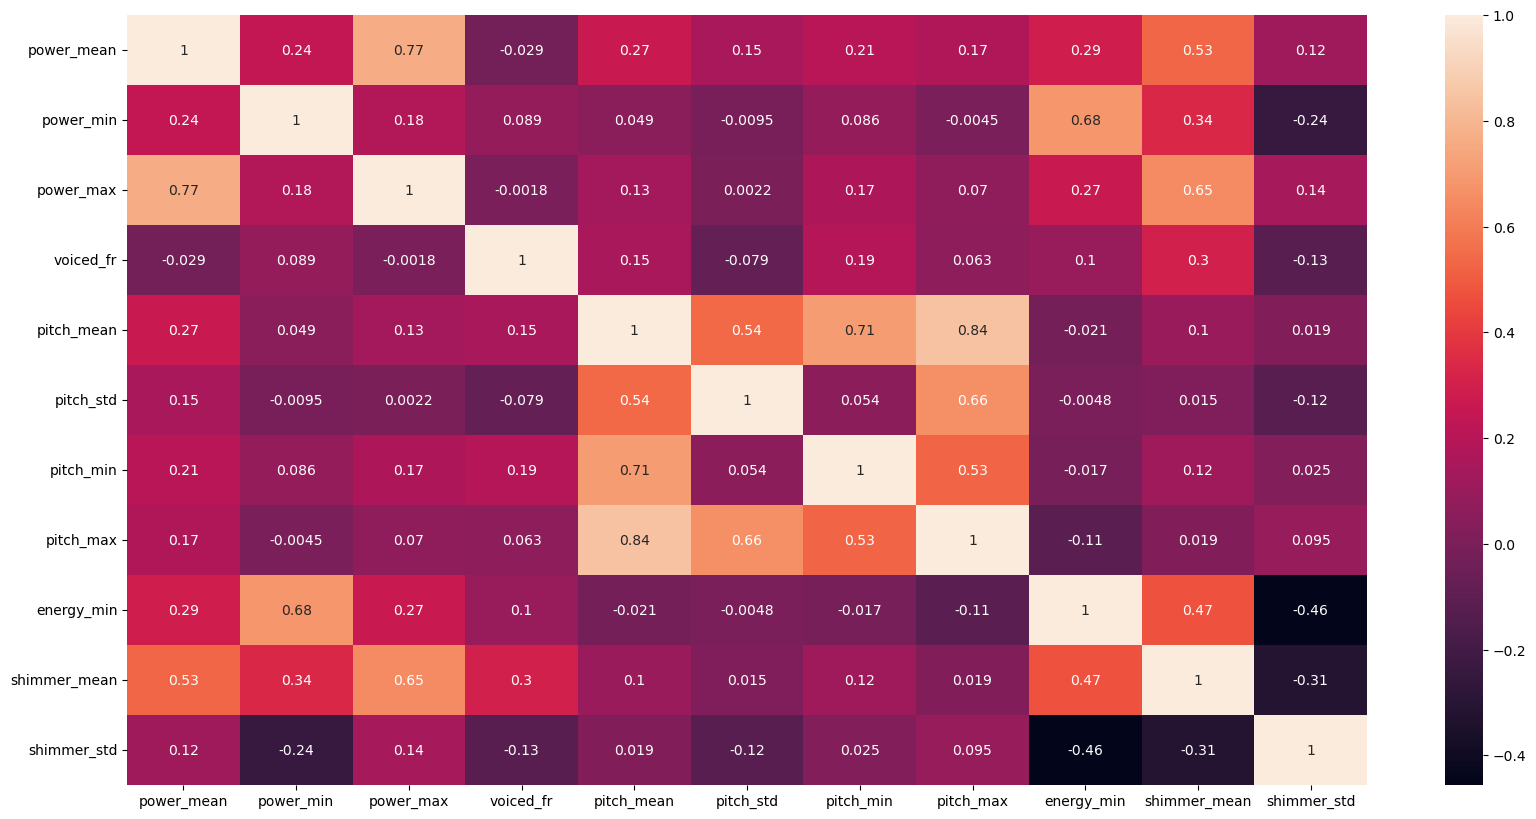

In [92]:
# create lists to allow seperation of feature groups
columns = X_train.columns
MFCC_columns = [column for column in columns if 'mfcc' in column]
non_MFCC_columns = [col for col in columns if 'mfcc' not in col]

# remove the highly correlated features
threshold = 0.85
X_train = remove_highly_correlated_features(X_train, threshold=threshold, switch_triangle=False)

# updates the columns from the training set 
columns = X_train.columns
MFCC_columns = [column for column in columns if 'mfcc' in column]
non_MFCC_columns = [col for col in columns if 'mfcc' not in col]

# remove the same columns from the test set
X_test = X_test[columns]

# create a new ploit for the correlation matrix
plot = plt.figure(figsize=(20, 10))
sns.heatmap(X_train[non_MFCC_columns].corr(), annot=True)

### 5.3.3 | MFCC Data PCA Analysis

As MFCCs are typically highly correlated and related - treating them as independent can lead to redundancy and overfitting. However the 13 coeficients provide distinct information that can be valuable for classification. Therefore a PCA feature reduction stage is performed seperate of the other features. 


Due to the features inherant relatedness, a PCA analysis is well suited to handle the related results for each coefficient. Since PCA looks at the overall variance, it inherently considers the relationships between the min, max,  mean and standard deviation of the same MFCC coefficients. Therefore, PCA is less likely to improperly separate these related features.

> * First the data is scaled with the `standard_scaler`
> * The Principal Component Analysis is performed with the `PCA` function on the MFCC data.
* To help visualise the variance explained by each component the following plots are made.
    * A **Cumulative Explained Variance by PCA Components** 
    * A**Scree Plot** 

* **The 2nd elbow of the scree plot is selected. 10 principle components capture 95% of the variance.**

* The resuling Heatmap shows the correlation between all remaining features.
    * It can be seen that there is at least 2 combination with ober 0.85.
>    * Therefore the `remove_highly_correlated_features()` function is called again


PCA applied to MFCC data
PCA applied to MFCC data
Highly correlated features removed: ['0']


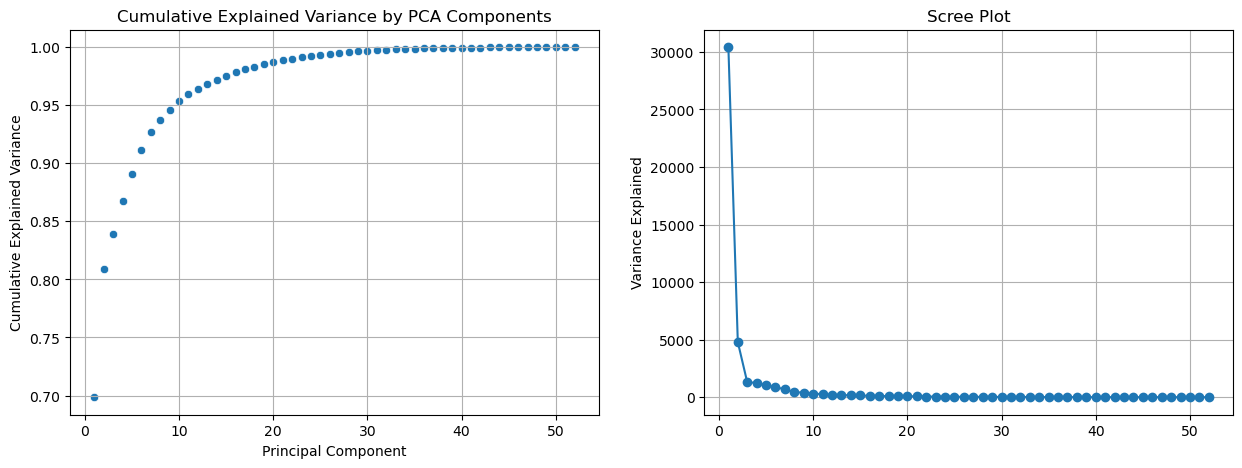

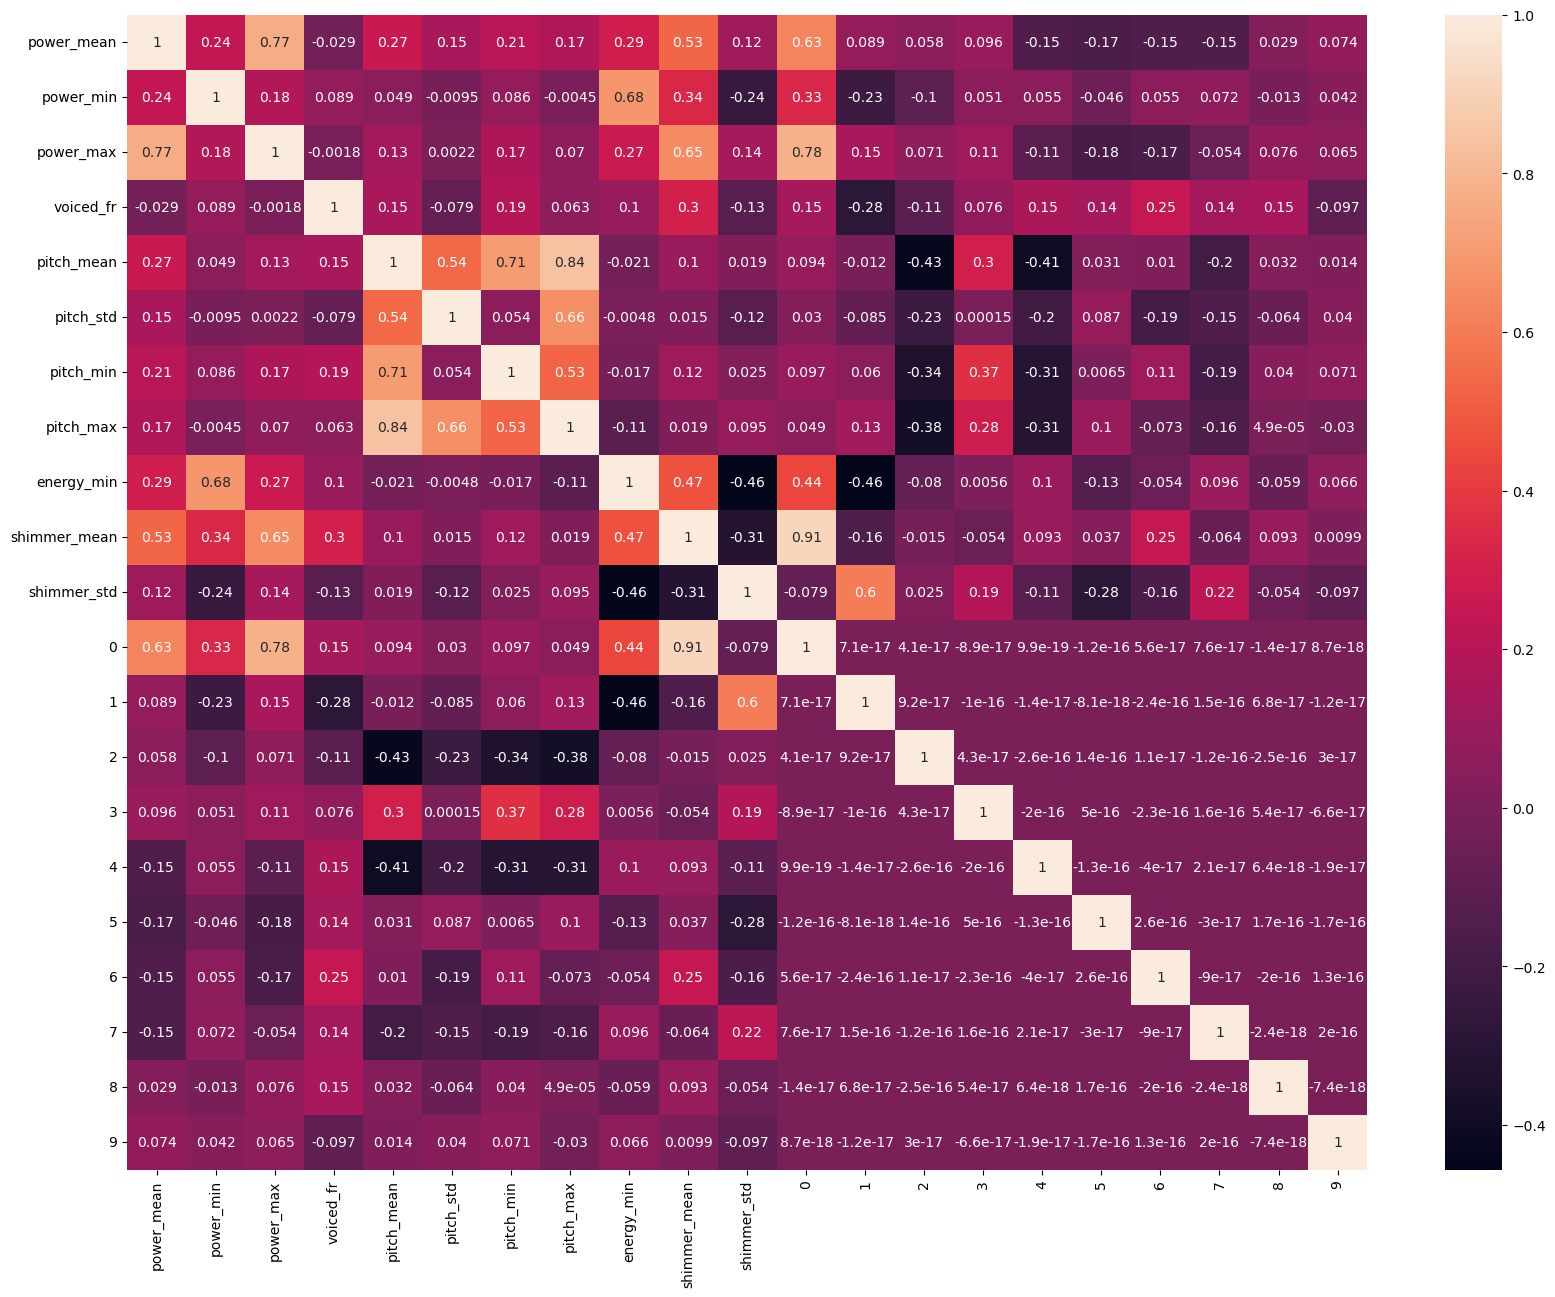

In [93]:
# Apply PCA for analysis
pca = PCA()
mfcc_pca = pca.fit_transform(X_train.loc[:, MFCC_columns])

# create subplots for the PCA analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
sns.scatterplot(x=range(1, len(cumulative_explained_variance) + 1), y=cumulative_explained_variance, ax=axes[0])
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('Cumulative Explained Variance by PCA Components')
axes[0].grid(True)

# Plot eigenvalues (variance explained by each principal component)
axes[1].plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o')
axes[0].set_xlabel('Principal Component')
axes[1].set_ylabel('Variance Explained')
axes[1].set_title('Scree Plot')
axes[1].grid(True)

# Select 10 principal components
X_train = apply_pca(X_train, n_components=10, train=True)
X_test = apply_pca(X_test, n_components=10, train=False)

# plot a heatmap of the correlation matrix for all features 
plot = plt.figure()
plot.set_size_inches(20, 15)
sns.heatmap(X_train.corr(), annot=True)

# run the correlation analysis again 
X_train = remove_highly_correlated_features(X_train, threshold=threshold, switch_triangle=False)

# ensue the test data has the same columns 
X_test = X_test[X_train.columns]

### 5.3.4 | Feature Reduction With RFECV

* A `random forest classifier` is trained to look at feature importance - which is plotted. 

>* The RFECV is performed with the `perform_RFECV()` function.

* The resulting `number_of_features` vs `cross_validation_accuracy` is plotted. 
* **pitch_mean**, **pitch_min**, **4**, **5**, **7** are removed.

Some observations are: 
* PCA component 2 has the highest importance.
* The cross validation accuracy shows an upwards pattern with the number of features selected.

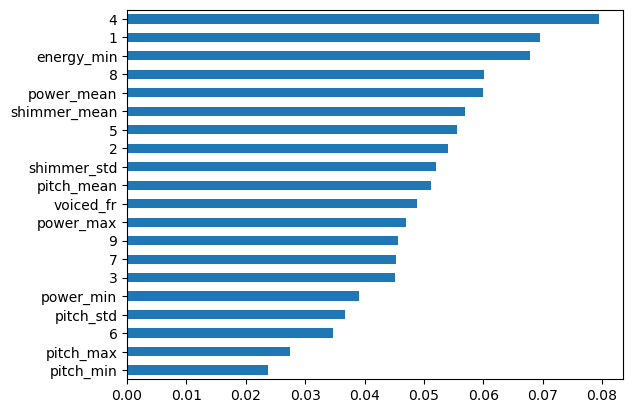

In [94]:
# # Train a Random Forest model to look at feature importance 
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns)
feature_importances.sort_values().plot(kind='barh')
plt.show()

# call the REC feature selection function
# X_train = perform_RFECV(X_train, y_train, min_features_to_select=1)

# ensure the test data has the same columns
X_test = X_test[X_train.columns]

### 5.3.5 | Final Data Visualisation

Now that there are a more managable set of features, a more comprehensive set of visualisation ploits can be performed. 

* Histograms
* Box Plots 
* Pair Plots

It can be seen that: 
* There are some patterns in the pair plot - some relationships exhibit triangular curved patters indication some relationships. 
* There is no significant correlation between any of the features.
* Power related feature All have a highly positive skew 
* PCA components all have distributions that are close to normal.


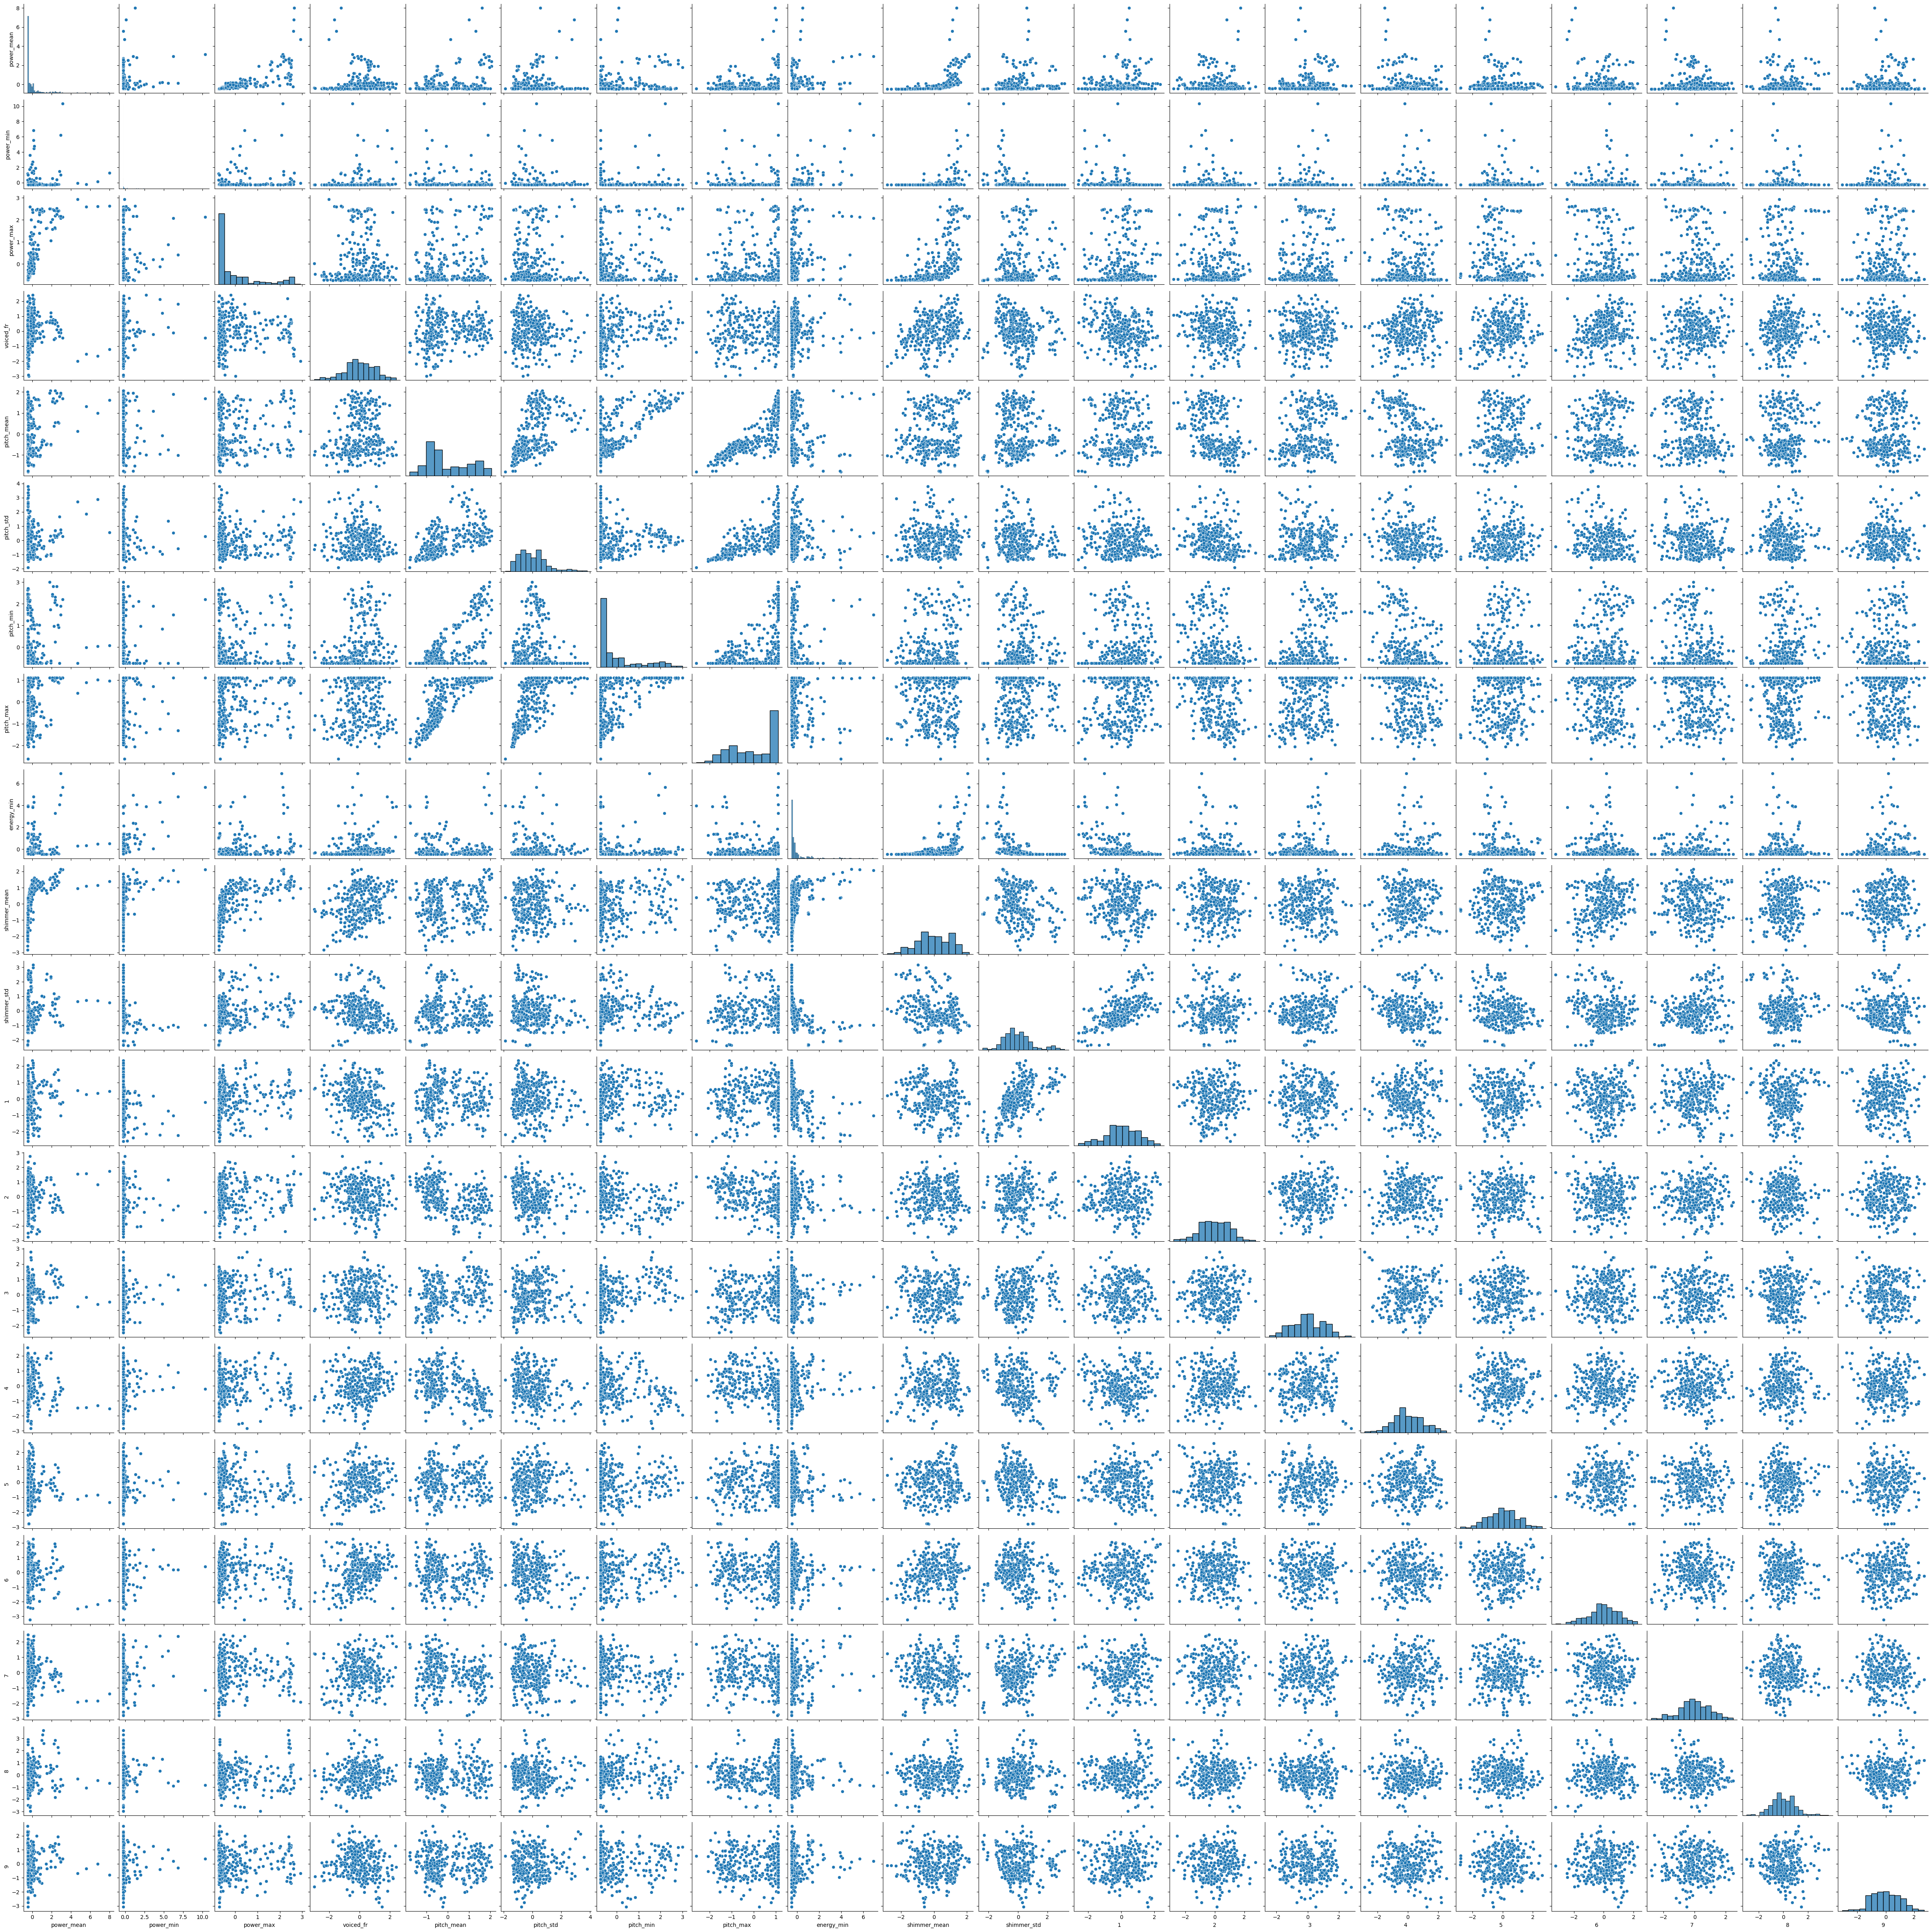

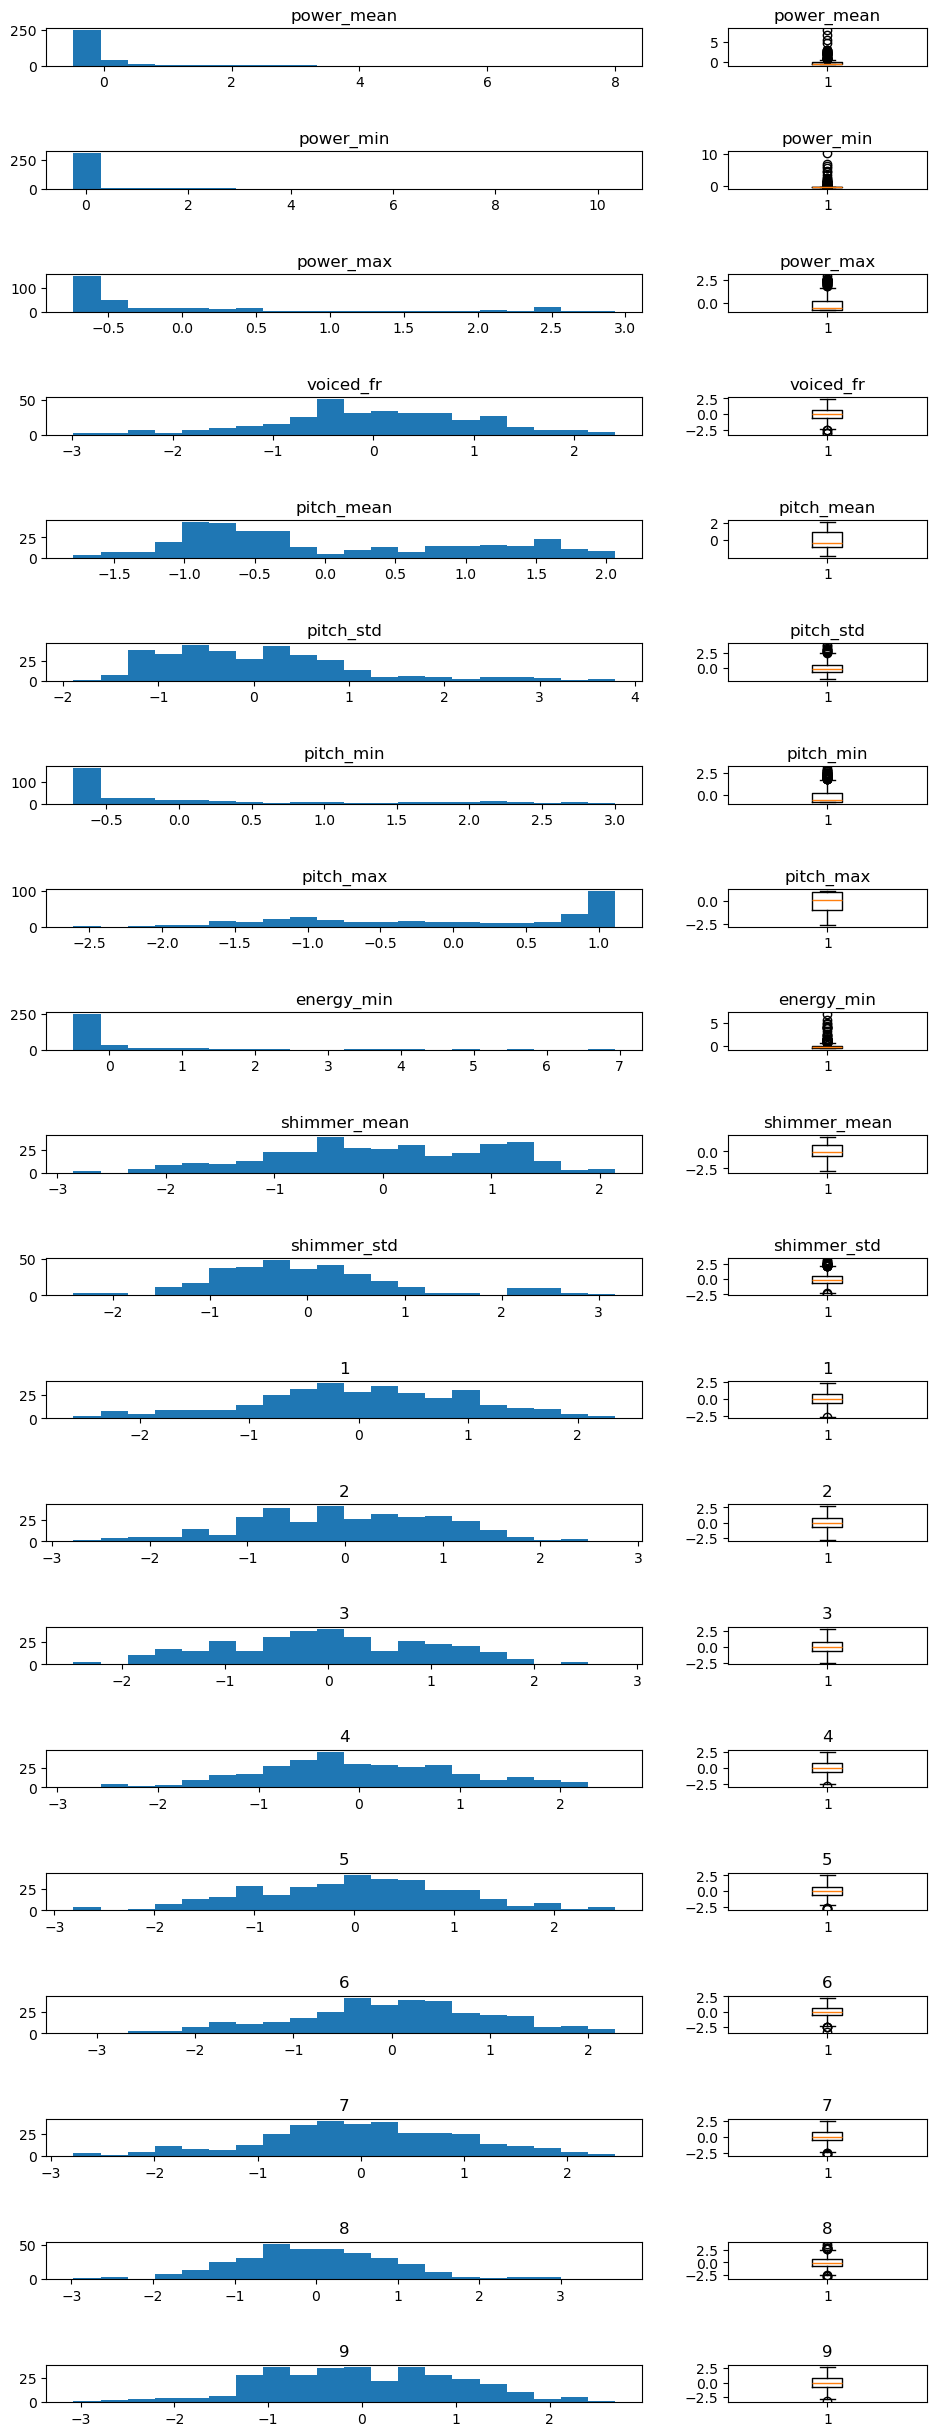

In [95]:
# plot a pairplot for the trainign data
sns.pairplot(X_train)

fig = plt.figure(figsize=(10, 25 )) 
gs = gridspec.GridSpec(len(X_train.columns), 2, width_ratios=[3,1])
axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(len(X_train.columns) * 2 )]

plot_tracker = 0
for  column in X_train.columns:
    # plot a histogram for the column
    axes[plot_tracker].hist(X_train[str(column)], bins=20)
    axes[plot_tracker].set_title(column)
    plot_tracker += 1

    # plot a boxplot for the column
    axes[plot_tracker].boxplot(X_train[str(column)])
    axes[plot_tracker].set_title(column)
    plot_tracker += 1

fig.tight_layout(pad=3)

## 6 | Experiment & Results 

### 6.1 | Tuning Model Hyperparameters
> The `tune_hyperparameters()` function is called. 
* The hyperparameters of the 5 models are tuned with the `GridSearchCV` function. The results are then stored in a `pandas` DataFrame.
* The model parameters are defined and controlled below. 
* The results of each model are stored in a `pandas` DataFrame.

| Model               | Mean Accuracy | Params                                       |
|---------------------|---------------|----------------------------------------------|
| Logistic Regression | 0.679429      | {'classifier__C': 10, 'classifier__penalty': 'l1'} |
| SVM                 | 0.902608      | {'classifier__C': 10, 'classifier__gamma': 'scale'} |
| Random Forest       | 0.856910      | {'classifier__max_depth': 20, 'classifier__min_samples_split': 2} |
| Gradient Boosting   | 0.848639      | {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100} |
| KNN                 | 0.915145      | {'classifier__algorithm': 'auto', 'classifier__n_neighbors': 5}     |

* The results of the model tuning suggest that some of the models are overfitted. With accuracy scores higher than expected. 
* This will be tested in the next stage using the test data

In [ ]:
# Define the models Grid parameters and the cross fold details
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2',],
        'classifier__solver': ['liblinear']
    }),
    'SVM': (SVC(probability=True), {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }),
    'Random Forest': (RandomForestClassifier(), {
        'classifier__n_estimators': [10, 50, 100],
        'classifier__max_depth': [5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.05],
        'classifier__max_depth': [3, 5, 7]
    }),
    'KNN': (KNeighborsClassifier(), {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto', 'ball_tree']
    })
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

tuning_results = tune_hyperparameters(X_train, y_train, models, cv)
tuning_results

Model  Mean Accuracy  \
0  Logistic Regression       0.679429   
1                  SVM       0.902608   
2        Random Forest       0.856910   
3    Gradient Boosting       0.848639   
4                  KNN       0.915145   

                                              Params  
0  {'classifier__C': 10, 'classifier__penalty': '...  
1  {'classifier__C': 10, 'classifier__gamma': 'sc...  
2  {'classifier__max_depth': 20, 'classifier__min...  
3  {'classifier__learning_rate': 0.1, 'classifier...  
4  {'classifier__algorithm': 'auto', 'classifier_...

### 6.2 | Ensemble Pipeline Model 

As highlited in the pipeline chapter. The final model is an ensemble of 5 classification models. The predictions of all 5 are combined and employs a VotingClassifier with 'soft' voting, meaning that the final prediction is based on the weighted average of the probabilities predicted by each base model.

**Testing Accuracy of Ensemble:**
| Metric               | Value                 |
|----------------------|-----------------------|
| **Ensemble Accuracy**   | 0.4819                |
| **Ensemble Precision**  | 0.3396                |
| **Ensemble Recall**     | 0.6923                |
| **Ensemble F1 Score**   | 0.4557                |

**Testing Accuracy of Each Model:**
| Model                 | Testing Accuracy      |
|-----------------------|-----------------------|
| **Logistic Regression**   | 0.6145                |
| **SVM**                    | 0.4337                |
| **Random Forest**          | 0.4337                |
| **Gradient Boosting**      | 0.4578                |
| **KNN**                    | 0.4819                |




In [ ]:
results = ensemble_voting_stage(X_train, y_train, X_test, y_test, voting='soft')
for model_name, model_predictions in results['Predictions'].items():
    print('in testing', model_name,'accuracy', accuracy_score(y_test, model_predictions))
    

# add the results to a csv file
with open('results.txt', 'w') as f:
    f.write(str(results))
results['Predictions']
for model, y_pred in results['Predictions'].items():
    

Ensemble Accuracy: 0.4096
Ensemble Precision: 0.3051
Ensemble Recall: 0.6923
Ensemble F1 Score: 0.4235
in testing Logistic Regression accuracy 0.6144578313253012
in testing SVM accuracy 0.42168674698795183
in testing Random Forest accuracy 0.3373493975903614
in testing Gradient Boosting accuracy 0.4939759036144578
in testing KNN accuracy 0.37349397590361444


{'Logistic Regression': array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 'SVM': array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64),
 'Random Forest': array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1], dtype=int64),
 'Gradient Boosting': array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 

# 7 | Conculsions

* asdasdads

# 8 | References

* **Libraries**
    * ski-kit learn ML library
    * Librosa - audio processing library
    * parselmouth - speech signal processing library

* **Resources**
    *  "Intelligent Audio Analysis" by Björn W. Schuller
    * "Towards interpretable speech biomarkers: exploring MFCCs" by Nature
    * "Classification in Machine Learning: A Guide for Beginners" by DataCamp